# Final Project
Yael Arbel, Jhonatha Navott, Itay Shukrunl, Timna Kleinman

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import pickle
import os.path
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import missingno as msno
import seaborn as sns
from multiprocessing.pool import ThreadPool
import requests
import urllib
import tqdm
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", None)

In [2]:
SHOULD_EXPLORE = False

# File Names:
DIR_PREFIX = "./"

SQLITE_RAW_FILE_NAME = DIR_PREFIX + "FPA_FOD_20170508.sqlite"
PICKLE_RAW_FILE_NAME = DIR_PREFIX + "raw_data.pkl"
PICKLE_PROCESSED_FILE_NAME = DIR_PREFIX + "processed_data.pkl"
PICKLE_LONG_LAT_TO_FIPS_SUB = DIR_PREFIX + "loc_to_fips/location_to_fips"
PICKLE_LONG_LAT_TO_FIPS = DIR_PREFIX + "location_to_fips.pkl"
PICKLE_TEST_DATA = "train_val_test_data/test.pkl"
PICKLE_TOTAL_TRAIN_DATA = "train_val_test_data/total train.pkl"
PICKLE_TOTAL_TRAIN_PREPROCESSED_DATA = "train_val_test_data/total train preprocessed.pkl"
PICKLE_PARTIAL_TRAIN_DATA = "train_val_test_data/partial_train_{i}_from_{folds}.pkl"
PICKLE_PARTIAL_VALIDATION_DATA = "train_val_test_data/partial_validation_{i}_from_{folds}.pkl"

LIGHTNING_DATA_FILE_NAME = DIR_PREFIX + "joined_lightning.csv"
HEAT_DATA_FILE_NAME = DIR_PREFIX + "joined_heat.csv"
WEATHER_DATA_FILE_NAME = DIR_PREFIX + "weather.csv"
INCOME_DATA_FILE_NAME = DIR_PREFIX + "income.csv"
POP_1990_2000_FILE_NAME = DIR_PREFIX + "POP1990.csv"
POP_2000_2010_FILE_NAME = DIR_PREFIX + "POP2000.csv"

ONE_HOT_COLUMNS = ['frequency_of_1.0', 'frequency_of_2.0', 'frequency_of_3.0', 'frequency_of_4.0', 'frequency_of_5.0',
               'frequency_of_6.0', 'frequency_of_7.0', 'frequency_of_8.0', 'frequency_of_9.0', 'frequency_of_10.0',
               'frequency_of_11.0', 'frequency_of_12.0', 'frequency_of_13.0', 'SOURCE_SYSTEM_TYPE_INTERAGCY',
               'SOURCE_SYSTEM_TYPE_NONFED', 'OWNER_CODE_1.0', 'OWNER_CODE_2.0', 'OWNER_CODE_3.0', 'OWNER_CODE_4.0',
               'OWNER_CODE_5.0', 'OWNER_CODE_6.0', 'OWNER_CODE_7.0', 'OWNER_CODE_8.0', 'OWNER_CODE_9.0', 'OWNER_CODE_10.0',
               'OWNER_CODE_11.0', 'OWNER_CODE_12.0', 'OWNER_CODE_13.0', 'OWNER_CODE_14.0', 'OWNER_CODE_15.0']

In [3]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
us_state_to_abbrev = {key.lower():value for key, value in us_state_to_abbrev.items()}


## Load Data

In [4]:
if os.path.isfile(PICKLE_RAW_FILE_NAME) :
    orig_df = pd.read_pickle(PICKLE_RAW_FILE_NAME)
else:
    conn = sqlite3.connect(SQLITE_RAW_FILE_NAME)
    orig_df = pd.read_sql_query("SELECT * from Fires", conn)
    orig_df.to_pickle(PICKLE_RAW_FILE_NAME)

## Explore

In [5]:
orig_df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [6]:
# Making sure we can leave one of the two, and don't need both:

if SHOULD_EXPLORE:
    orig_df.groupby("STAT_CAUSE_DESCR")["STAT_CAUSE_CODE"].nunique()

In [7]:
if SHOULD_EXPLORE:
    orig_df["STAT_CAUSE_DESCR"].value_counts().plot.bar()

In [8]:
# number of values for each column:

if SHOULD_EXPLORE:
    msno.bar(orig_df)

The misssing values heatmap teaches us that:<br>
    1. COUNTY and FIPS_NAME and FIPS_CODE are missing together and can't be used to inputate each other<br>
    2. Same goes for CONT_DOY CONT_DATE - and CONT_TIME and DISCOVERY_DATE missing
        values are highly correlated to that as well.
    

In [9]:
if SHOULD_EXPLORE:
    msno.heatmap(orig_df[['FIRE_NAME', 'DISCOVERY_TIME', 'CONT_DATE','CONT_DOY', 'CONT_TIME', 'COUNTY',
                          'FIPS_CODE', 'FIPS_NAME']])

In [10]:
# Number of unique values in each column - cardinality:

if SHOULD_EXPLORE:
    orig_df.nunique()

Can assume OBJECTID, FOD_ID, FPA_ID will give us same information, each value is unique.
We can see which feature can be used as categorical, and which required binning.

In [11]:
# Exploring correlations before proccessing:

if SHOULD_EXPLORE:
    cause_categorical = pd.get_dummies(orig_df["STAT_CAUSE_DESCR"])

In [12]:
# Exploring correlation with state:
    
if SHOULD_EXPLORE:
    state_categorical = pd.get_dummies(orig_df["STATE"])
    state_cause = pd.concat([state_categorical,cause_categorical],axis=1)

    plt.subplots(figsize=(20, 20))
    sns.heatmap(state_cause.corr("pearson"))
    plt.show()

As we can see above, some states relate to specific fire cause, FL to railroad PR have missing information
and NY with misc

In [13]:
# Normalizing:

if SHOULD_EXPLORE:
    time_and_place = orig_df[["LATITUDE", "LONGITUDE", "DISCOVERY_DATE", "DISCOVERY_DOY", "FIRE_SIZE"]].copy()
    time_and_place["DISCOVERY_DOY"] = np.sin(orig_df["DISCOVERY_DOY"]*2*np.pi / 365)
    time_and_place["FIRE_SIZE_CLASS"] = orig_df["FIRE_SIZE_CLASS"].apply(ord) - ord('A') + 1
    time_and_place = pd.concat([time_and_place,cause_categorical],axis=1)
    time_and_place.head()

In [14]:
# Exploration correolation with time and place:

if SHOULD_EXPLORE:
    plt.subplots(figsize=(15, 15))
    sns.heatmap(time_and_place.corr("pearson"))
    plt.show()

In [15]:
if SHOULD_EXPLORE:
    orig_df.groupby(['NWCG_REPORTING_AGENCY']).size()

We can see SOURCE_SYSTEM_TYPE(Type of source database or system that the record was drawn from) have some
correlation with fire cause, FED relate to Lightning,
INTERAGCY to missing cause, and NONFED to debris.
We can see coordinates relate to SOURCE_SYSTEM_TYPE  as well.


In [16]:
# Exploration correlation with agencies:

if SHOULD_EXPLORE:
    system_cause = pd.get_dummies(orig_df["SOURCE_SYSTEM_TYPE"])
    system_cause = pd.concat([system_cause,pd.get_dummies(orig_df["NWCG_REPORTING_AGENCY"])],axis=1)
    system_cause = pd.concat([system_cause,cause_categorical],axis=1)
    plt.subplots(figsize=(15, 15))
    sns.heatmap(system_cause.corr("pearson"))
    plt.show()

We can see strong relation with SOURCE_SYSTEM_TYPE (Type of source database or system that the record was drawn from) and both NWCG_REPORTING_AGENCY and SOURCE_SYSTEM(FED,INTERAGCY,NONFED - identifier for source database),
Some agencies have weak relation to fire cause, FLFLS to Railroad for example, probably florida relation again.

This shows that system types and NCWG reporting units hold simillar information regarding the fire cause type,
thus we've decided to use only source system type due to it's low cardinality

In [17]:
# Exploration correlation between existing fire name and agency:

if SHOULD_EXPLORE:
    name_cause = orig_df.FIRE_NAME.apply(lambda x: 1 if not x else 0)
    name_cause = pd.concat([name_cause,pd.get_dummies(orig_df["NWCG_REPORTING_AGENCY"])],axis=1)
    name_cause = pd.concat([name_cause,cause_categorical],axis=1)
    plt.subplots(figsize=(15, 15))
    sns.heatmap(name_cause.corr("pearson"))
    plt.show()

NWCG_REPORTING_AGENCY (Unit Identifier for the agency preparing the fire report) have some relation to fire cause
IA relate to missing, FS and BLM to lightning. This isn't surprising as we found FED relate to FS and BLM and
INTERAGCY relate to IA, based on previous correlation.

In [18]:
# Exploration correlation with owner codes:

if SHOULD_EXPLORE:
    owner_cause = pd.get_dummies(orig_df["OWNER_CODE"])
    owner_cause = pd.concat([owner_cause,cause_categorical],axis=1)
    plt.subplots(figsize=(15, 15))
    sns.heatmap(owner_cause.corr("pearson"))
    plt.show()

In [19]:
# This graph shows the need of a logarithmic scale:

if SHOULD_EXPLORE:
    orig_df.groupby(['FIRE_SIZE_CLASS'])['FIRE_SIZE'].mean().plot()
    plt.title('Fire size mean by class')
    plt.ylabel('mean size')

In [20]:
# Amounts in each fire size:

if SHOULD_EXPLORE:
    orig_df.groupby(['FIRE_SIZE_CLASS'])['FIRE_SIZE'].size()

In [21]:
# Looking at fire_size_class after binning vs. stat_cause_code:

if SHOULD_EXPLORE:
    fire_class_df = orig_df[['FIRE_SIZE_CLASS']].copy()
    fire_class_df[['FIRE_SIZE_CLASS']] = fire_class_df[['FIRE_SIZE_CLASS']].replace({
        'A':'A', 'B':'B', 'C': 'C', 'D': 'other', 'E': 'other', 'G': 'other', 'F': 'other'\
        })
    fire_class_df = pd.get_dummies(fire_class_df["FIRE_SIZE_CLASS"])
    fire_class_df = pd.concat([fire_class_df,cause_categorical],axis=1)

    plt.subplots(figsize=(15, 15))
    sns.heatmap(fire_class_df.corr("pearson"))
    plt.show()

In [22]:
# Looking at fire_size and fire_size_class after binning vs. stat_cause_code:

if SHOULD_EXPLORE:
    fire_class_df = orig_df[['FIRE_SIZE']].copy()
    fire_class_df[['FIRE_SIZE_CLASS']] = np.log(fire_class_df[['FIRE_SIZE']])
    fire_class_df = pd.concat([fire_class_df,cause_categorical],axis=1)

    plt.subplots(figsize=(15, 15))
    sns.heatmap(fire_class_df.corr("pearson"))
    plt.show()

In [23]:
# Weekday per stat_cause:

if SHOULD_EXPLORE:
    time_df = orig_df[["STAT_CAUSE_DESCR"]].copy()

    time_df["WEEKDAY"] = (pd.to_datetime(orig_df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')).dt.weekday

    time_pivot = time_df.pivot_table(index=["STAT_CAUSE_DESCR"], columns=['WEEKDAY'], aggfunc=np.size)/2 #TODO - WTF
    total_amount = np.array([time_df.groupby(["STAT_CAUSE_DESCR"]).size()]).T

    sns.heatmap(np.divide(time_pivot, total_amount), cmap="YlGnBu")

In [24]:
# Holiday per stat_cause:

if SHOULD_EXPLORE:
    time_df["WEEKEND"] = time_df['WEEKDAY'].isin([5,6]) * 1

    time_pivot = time_df.pivot_table(index=["STAT_CAUSE_DESCR"], columns=['WEEKEND'], aggfunc=np.size)
    total_amount = np.array([time_df.groupby(["STAT_CAUSE_DESCR"]).size()]).T

    sns.heatmap(np.divide(time_pivot, total_amount), cmap="YlGnBu")

### Outer Data Exploration:

In [25]:
#The mean income rises through the years, thus needed to be normalized before inputing:

if SHOULD_EXPLORE:
    pre_income_df = pd.read_csv(INCOME_DATA_FILE_NAME)
    years = [str(i) for i in range(1991, 2017)]
    pre_income_df[years].mean().plot()
    plt.title('Mean income over year')
    plt.xlabel('Year')
    plt.ylabel('mean income')

## Pre Processing

### Correct Features:

In [26]:
def correct_columns(df):
    df['FIPS_NAME'] = df['FIPS_NAME'].str.lower()
    df['FIPS_NAME'] = df['FIPS_NAME'].str.strip()
    
    df["FIRE_SIZE_CLASS"] = df["FIRE_SIZE_CLASS"].replace({'A':'A', 'B':'B',
                                                           'C': 'C', 'D': 'D',
                                                           'E': 'D', 'G': 'D', 'F': 'D' }) # Binning
    
    # Other columns - from fire_size_class letter to ordinary number - 
    df["FIRE_SIZE_CLASS"] = df["FIRE_SIZE_CLASS"].apply(ord) - ord('A') + 1
    
    return df

### Add Features:

In [27]:
# Columns that are added as is:

def add_general_columns(df):
    fixed_df = df[["LATITUDE", "LONGITUDE", "FIRE_YEAR", "STAT_CAUSE_CODE", "FIRE_SIZE", "FIRE_SIZE_CLASS"]].copy()
    return df, fixed_df

In [28]:
# Time columns:

def add_time_columns(df, fixed_df):

    discovery_date = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
    df["DATE"] = discovery_date.dt.date
    df["FIRE_MONTH"] = discovery_date.dt.month

    month_norm = (discovery_date.dt.month - 1) / (12 - 1) # From 1 to 12

    fixed_df["SIN_DISCOVERY_MONTH"] = np.sin(2 * np.pi * month_norm)
    fixed_df["COS_DISCOVERY_MONTH"] = np.cos(2 * np.pi * month_norm)

    fixed_df['WEEKEND'] = discovery_date.dt.weekday.isin([5, 6]) * 1
    weekday_norm = discovery_date.dt.weekday / (7 - 1) # From 0 to 6

    cal = calendar()
    holidays = cal.holidays(start=discovery_date.min(), end=discovery_date.max())

    fixed_df['Holiday'] = discovery_date.isin(holidays) * 1

    fixed_df["SIN_DISCOVERY_WEEKDAY"] = np.sin(2 * np.pi * weekday_norm)
    fixed_df["COS_DISCOVERY_WEEKDAY"] = np.cos(2 * np.pi * weekday_norm)
    return df, fixed_df

In [29]:
# Fill FIPS by using longitude and latitude:

def get_location_to_FIPS_df(df):
    if os.path.isfile(PICKLE_LONG_LAT_TO_FIPS):
        fips_df = pd.read_pickle(PICKLE_LONG_LAT_TO_FIPS)
    else:
        tq = tqdm.tqdm(len(df[df["FIPS_CODE"].isna()]))
        temp_df_fips = df[df["FIPS_CODE"].isna()]
        for i in range(int(len(temp_df_fips) / chunk_size) + 1):
            small_pickle_name = f'{PICKLE_LONG_LAT_TO_FIPS_SUB}_{i * chunk_size}.pkl'
            tq.refresh()
            if os.path.isfile(small_pickle_name):
                continue
            small_fips_df = add_FIPS(temp_df_fips.iloc[i * chunk_size : i * chunk_size + chunk_size])
            small_fips_df.to_pickle(small_pickle_name)
        frames = []
        for i in range(int(len(temp_df_fips) / chunk_size) + 1):
            curr_fips_df = pd.read_pickle(f'{PICKLE_LONG_LAT_TO_FIPS_SUB}_{i * chunk_size}.pkl')
            frames.append(curr_fips_df)
        fips_df = pd.concat(frames)
        fips_df.to_pickle(PICKLE_LONG_LAT_TO_FIPS)
    return fips_df

def add_FIPS(df):
    process_pool = ThreadPool(70)
    data_to_send = list(df[["LATITUDE","LONGITUDE"]].to_records(index=False))
    res = process_pool.starmap(thread_fill_FIPS, data_to_send)
    new_df = df[["LATITUDE", "LONGITUDE"]].copy()
    new_df["NEW_FIPS"] = res
    return new_df

def thread_fill_FIPS(latitude, longitude):
    for i in range(15):
        try:
            params = urllib.parse.urlencode({'latitude': latitude, 'longitude':longitude, 'format':'json'})

            # Contruct request URL
            url = 'https://geo.fcc.gov/api/census/block/find?' + params
            
            # Get response from API
            response = requests.get(url)

            # Parse json in response
            data = response.json()

            if data["status"] == "error":
                continue

            # Return FIPS code
            tq.update()
            return data['County']['FIPS'][2:]
        except Exception:
            continue
    tq.update()
    return None


def imputate_fips(df, fixed_df):
    chunk_size = 10_000
    
    fips_df = get_location_to_FIPS_df(df)
    df = df.merge(fips_df, how='left', left_on=["LATITUDE","LONGITUDE"], right_on=["LATITUDE","LONGITUDE"])
    
    df["FIPS_CODE"] = df["NEW_FIPS"].combine_first(df["FIPS_CODE"])
    df = df.drop(columns=["NEW_FIPS"])
    return df, fixed_df

In [30]:
def add_weather_events(df, fixed_df):
    weather_events = pd.read_csv("weather_events.csv")
    weather_events["DATE"] = pd.to_datetime(weather_events["DATE"])
    df["DATE_for_weather_events"] = pd.to_datetime(df["DATE"])
    df = df.merge(weather_events,"left",left_on=["DATE_for_weather_events","STATE"],right_on = ["DATE","STATE"])
    fixed_df[["OTHER_EVENT","HAIL","WIND","HEAT","LIGHTNING","DROUGHT","FLOOD","RAIN_SNOW","WILDFIRE"]] = df[["OTHER_EVENT","HAIL","WIND","HEAT","LIGHTNING","DROUGHT","FLOOD","RAIN_SNOW","WILDFIRE"]]
    return df,fixed_df

In [31]:
# Add columns about temperature and income:

def parse_weather_data(weather_data):
    """
    Parses state mean weather before inputing
    """
    weather_data['month'] = weather_data['Date'].astype(int) % 100
    weather_data['year'] = (weather_data['Date'].astype(int ) / 100).astype(int)
    weather_data['Location'] = weather_data['Location'].str.lower()
    
    return weather_data

def parse_income_data(income_data):
    """
    Parses state mean income before inputing
    """
    income_data['GeoName'] =\
    income_data['GeoName'].str.lower().str.replace(' \*', '')
    for i in range(1991, 2018):
        gen_mean = income_data[[str(i)]].iloc[0][0]
        income_data[str(i)] = (income_data[str(i)].to_numpy() - gen_mean) / gen_mean
    return income_data

def add_temperature_and_income(df, fixed_df):
    weather_df = pd.read_csv(WEATHER_DATA_FILE_NAME)
    income_df = pd.read_csv(INCOME_DATA_FILE_NAME)

    df_state_temp = df['STATE']
    weather_df = parse_weather_data(weather_df)
    income_df = parse_income_data(income_df)

    df.loc[df['STATE'] == 'PR', 'STATE'] = 'HI'
    
    income_df = income_df.replace({"GeoName": us_state_to_abbrev})
    income_df = income_df.melt(id_vars=["GeoFips", "GeoName"], var_name="Year", value_name="mean_month_income")
    income_df["Year"] = income_df["Year"].astype(np.int64)
    df = df.merge(income_df[['GeoName', 'Year', 'mean_month_income']], how='left', left_on=['STATE', 'FIRE_YEAR'],
                  right_on=['GeoName', 'Year']).drop(columns=['GeoName', 'Year'])

    df['STATE'] = df_state_temp
    df.loc[df['STATE'] == 'PR', 'STATE'] = 'FL'
    df.loc[df['STATE'] == 'HI', 'STATE'] = 'CA'
    df.loc[df['STATE'] == 'DC', 'STATE'] = 'MD'
    df.loc[df['STATE'] == 'AK', 'STATE'] = 'WA'
    weather_df["year"] = weather_df["year"].astype(np.int64)
    weather_df["month"] = weather_df["month"].astype(np.int64)
    weather_df = weather_df.replace({"Location": us_state_to_abbrev})
    df = df.merge(weather_df[['Location', 'month', 'year','Value']], how='left', left_on=['STATE', 'FIRE_MONTH', 'FIRE_YEAR'],
                  right_on=['Location', 'month', 'year']).rename(columns={"Value": "state_monthly_weather"})\
                .drop(columns=['Location', 'month', 'year'])

    df['STATE'] = df_state_temp
    fixed_df["TEMPERATURE"] = df['state_monthly_weather']
    fixed_df["INCOME"] = df['mean_month_income']
    return df, fixed_df

In [32]:
# This cell adds population per county (NEW FIPS), state and year:

def add_population(df, fixed_df):
    pop_1990_2000_df = pd.read_csv(POP_1990_2000_FILE_NAME)
    pop_2000_2010_df = pd.read_csv(POP_2000_2010_FILE_NAME)
    all_pop = pd.concat([pop_1990_2000_df, pop_2000_2010_df], axis=0, ignore_index=True)
    all_pop.county = all_pop['county'].astype(str).str.zfill(3)
    all_pop.stname = all_pop.stname.str.lower().str.strip()
    all_pop = all_pop.replace({"stname": us_state_to_abbrev}).drop_duplicates()
    df = df.merge(all_pop[['stname', 'year','county', 'tot_pop']], how='left', left_on=['STATE', 'FIRE_YEAR', 'FIPS_CODE'],
                  right_on=['stname', 'year','county']).rename(columns={"tot_pop": "TOTAL_POPULATION"})\
                .drop(columns=['stname', 'year','county'])
    df["TOTAL_POPULATION"].fillna(all_pop['tot_pop'].mean(), inplace=True)
    fixed_df['TOTAL_POPULATION'] = df['TOTAL_POPULATION']
    return df, fixed_df

In [33]:
# Add frequency of each response by location (state and FIPS) and month:

def add_frequency(df, fixed_df, is_train, freq_of_fire_type_by_location_and_month=None,
                  num_of_fires_by_location_and_month=None):
    NEEDED_COLS = ['FIRE_MONTH', 'STATE', 'FIPS_CODE']
    fixed_df[NEEDED_COLS] = df[NEEDED_COLS]
    if is_train:
        freq_of_fire_type_by_location_and_month = df.pivot_table(index=NEEDED_COLS, columns=['STAT_CAUSE_CODE'],
                                                                 aggfunc=np.size, values=['COMPLEX_NAME'])['COMPLEX_NAME']
        num_of_fires_by_location_and_month = df.groupby(NEEDED_COLS).size()
        freq_of_fire_type_by_location_and_month = freq_of_fire_type_by_location_and_month.merge(
                                                    num_of_fires_by_location_and_month.rename("total_amount"), how='left',
                                                    left_on=NEEDED_COLS, right_index=True)
        freq_of_fire_type_by_location_and_month = freq_of_fire_type_by_location_and_month.div(
                                                    freq_of_fire_type_by_location_and_month['total_amount'], axis=0)\
                                                    .drop('total_amount', axis=1).add_prefix('frequency_of_')
    fixed_df = fixed_df.merge(freq_of_fire_type_by_location_and_month, how='left', left_on=NEEDED_COLS, right_index=True)
    fixed_df = fixed_df.merge(num_of_fires_by_location_and_month.rename("fires_per_location_and_month"),
                              how='left', left_on=NEEDED_COLS, right_index=True)
    fixed_df = fixed_df.drop(columns=NEEDED_COLS)
    
    freq_base_str = 'frequency_of_{num}.0'

    for i in range(0, 14):
        col_name = freq_base_str.format(num=i)
        if col_name in fixed_df.columns:
            fixed_df[col_name].fillna(0, inplace=True)
    fixed_df["fires_per_location_and_month"].fillna(0, inplace=True)
    return df, fixed_df, freq_of_fire_type_by_location_and_month, num_of_fires_by_location_and_month

### One Hot:

In [34]:
# One hot encoding columnms:

def do_one_hot(df, fixed_df):
    dummie_columns = ["SOURCE_SYSTEM_TYPE", "OWNER_CODE"]
    fixed_df["SOURCE_SYSTEM_TYPE"] = df["SOURCE_SYSTEM_TYPE"]
    fixed_df["OWNER_CODE"] = df["OWNER_CODE"]
    fixed_df = pd.get_dummies(fixed_df, columns=dummie_columns, drop_first=True)
    
    return df, fixed_df

### Remove Outliers:

In [35]:
def remove_outliers(fixed_df):
    isf = IsolationForest(max_samples=5_000)
    isf.fit(train_df)
    is_outlier = isf.predict(train_df)
#     np.count_nonzero(is_outlier + 1)/len(is_outlier) # Num of inliers

    # TODO: remove the outliers

### Normalize:

In [36]:
# Normalize:

GLOBAL_MIN_MAX_DICT = {'LONGITUDE':(-178.8026, -65.25694444),
                'LATITUDE':(17.93972222, 70.3306),
                'FIRE_YEAR':(1992, 2015)}

NORM_COLS = ['TEMPERATURE']
TRAIN_MIN_MAX = ['fires_per_location_and_month']
LOGGED = ['FIRE_SIZE', 'TOTAL_POPULATION']


def _min_max_norm(fixed_df, col_name, col_range):
    """
    Performs min max normalization
    """
    col_min, col_max = col_range
    fixed_df[col_name] = (fixed_df[col_name] - col_min) / (col_max - col_min)
    return fixed_df


def normalize(fixed_df, is_train, norm_dict=None, train_min_max_dict=None, logged_dict=None):
    """
    Normalizes the needed cols by three different logic schemes:
        1. min max normalization for non leaky data e.g long lat (by america size)
        2. normalize by mean and std of train data
        3. min max by train data
        4. log normalization 
    """
    for col, col_range in GLOBAL_MIN_MAX_DICT.items():
        fixed_df = _min_max_norm(fixed_df, col, col_range)
    if is_train:
        norm_dict = dict()
        train_min_max_dict = dict()
        logged_dict = dict()
        for col in NORM_COLS:
            norm_dict[col] = (fixed_df[col].mean(), fixed_df[col].std())
        for col in TRAIN_MIN_MAX:
            train_min_max_dict[col] = (fixed_df[col].min(), fixed_df[col].max())
        for col in LOGGED:
            logged_dict[col] = (np.log(fixed_df[col].min()), np.log(fixed_df[col].max()))
    for col, mean_std in norm_dict.items():
        fixed_df[col] = (fixed_df[col] - mean_std[0]) / mean_std[1]
    for col, col_range in train_min_max_dict.items():
        fixed_df = _min_max_norm(fixed_df, col, col_range)
    for col, col_range in logged_dict.items():
        fixed_df[col] = np.log(fixed_df[col])
        fixed_df = _min_max_norm(fixed_df, col, col_range)
    return fixed_df, norm_dict, train_min_max_dict, logged_dict

### Add Missing Columns:

In [37]:
def add_missing_columns(fixed_df):
    missing_columns = set(ONE_HOT_COLUMNS).difference(set(fixed_df.columns))
    for col in missing_columns:
        fixed_df[col] = 0
    return fixed_df

### Test vs Train pre-processing pipeline:

In [38]:
def train_pre_processing(train_df, i="!"):
    df = train_df.copy()
    
    df = correct_columns(df)
    # print("done-train: correct_columns")
    df, fixed_df = add_general_columns(df)
#     print("done-train: add_general_columns")
    df, fixed_df = add_time_columns(df, fixed_df)
#     print("done-train: add_time_columns")
    df, fixed_df = imputate_fips(df, fixed_df)
#     print("done-train: imputate_fips")
    df,fixed_df = add_weather_events(df,fixed_df)
#     print("done-train: weather_events")
    df, fixed_df = add_temperature_and_income(df, fixed_df)
#     print("done-train: add_temperature_and_income")
    df, fixed_df = add_population(df, fixed_df)
#     print("done-train: add_population")
    df, fixed_df, freq_of_fire_type_by_location_and_month, num_of_fires_by_location_and_month = \
                                                                                    add_frequency(df, fixed_df, True)
#     print("done-train: add_frequency")
    df, fixed_df = do_one_hot(df, fixed_df)
#     print("done-train: do_one_hot")

#     df = remove_outliers(df)
#     print("done-train: remove_outliers")

    fixed_df, norm_dict, train_min_max_dict, logged_dict = normalize(fixed_df, True)
#     print("done-train: normalize")
    
    fixed_df = add_missing_columns(fixed_df)
    
    print(f"**********DONE TRAIN{i}!!!**********")
    return fixed_df, freq_of_fire_type_by_location_and_month, num_of_fires_by_location_and_month, \
            norm_dict, train_min_max_dict, logged_dict


def test_pre_processing(test_df, freq_of_fire_type_by_location_and_month,
                        num_of_fires_by_location_and_month, norm_dict, train_min_max_dict, logged_dict, i="!"):
    df = test_df.copy()
    
    df = correct_columns(df)
#     print("done-test: correct_columns")
    df, fixed_df = add_general_columns(df)
#     print("done-test: add_general_columns")
    df, fixed_df = add_time_columns(df, fixed_df)
#     print("done-test: add_time_columns")
    df, fixed_df = imputate_fips(df, fixed_df)
#     print("done-test: imputate_fips")
    df,fixed_df = add_weather_events(df,fixed_df)
#     print("done-test: weater_events")
    df, fixed_df = add_temperature_and_income(df, fixed_df)
#     print("done-test: add_temperature_and_income")
    df, fixed_df = add_population(df, fixed_df)
#     print("done-test: add_population")
    df, fixed_df, _, _ = add_frequency(df, fixed_df, False, freq_of_fire_type_by_location_and_month, 
                                      num_of_fires_by_location_and_month)
#     print("done-test: add_frequency")
    df, fixed_df = do_one_hot(df, fixed_df)
#     print("done-test: do_one_hot")
    fixed_df, _, _, _ = normalize(fixed_df, False, norm_dict, train_min_max_dict, logged_dict)
#     print("done-test: normalize")

    fixed_df = add_missing_columns(fixed_df)
    
    print(f"**********DONE TEST{i}!!!**********")
    return fixed_df

## Exploration after Pre-Processing

In [39]:
if SHOULD_EXPLORE:
    train_df, test_df = train_test_split(orig_df, test_size=0.3, random_state=0)


    train_df.reset_index(inplace=True)
    test_df.reset_index(inplace=True)

    # Train:
    train_df, freq_of_fire_type_by_location_and_month, \
            num_of_fires_by_location_and_month, norm_dict, train_min_max_dict, logged_dict = train_pre_processing(train_df)
    #train model

    # Test:
    test_df = test_pre_processing(
                    test_df, freq_of_fire_type_by_location_and_month,
                    num_of_fires_by_location_and_month,
                    norm_dict, train_min_max_dict, logged_dict)

In [40]:
# Stat code distribution over all features:

if SHOULD_EXPLORE:
    not_for_boxplot = ["STAT_CAUSE_CODE", "FIRE_SIZE_CLASS", "Holiday", "WEEKEND", "COS_DISCOVERY_WEEKDAY", "SIN_DISCOVERY_WEEKDAY"]
    box_plot_rel_cols = [col for col in train_df.columns if not ((col in not_for_boxplot) or col.startswith('OWNER') or
                                                                 col.startswith('frequency_') or
                                                                 col.startswith('SOURCE_SYSTEM_TYPE'))]
    fig, axs = plt.subplots(len(box_plot_rel_cols), sharex=True, figsize=(10,50))
    for i, col in enumerate(box_plot_rel_cols):
        sns.boxplot(x='STAT_CAUSE_CODE', y=col, data=train_df, ax=axs[i])
    plt.show()

In [41]:
# Holiday per stat_cause:

if SHOULD_EXPLORE:
    holiday_df = train_df[["STAT_CAUSE_CODE", "Holiday"]].copy()

    holiday_pivot = holiday_df.pivot_table(index=["STAT_CAUSE_CODE"], columns=['Holiday'], aggfunc=np.size)/2 #TODO - WTF
    holiday_amount = np.array([holiday_df.groupby(["STAT_CAUSE_CODE"]).size()]).T

    sns.heatmap(np.divide(holiday_pivot, holiday_amount), cmap="YlGnBu")

## Train, Test and Validation - Split and Run Model

### Split:

In [42]:
# Split to train - test:

if not os.path.isfile(PICKLE_TEST_DATA) or not os.path.isfile(PICKLE_TOTAL_TRAIN_DATA) \
    or not os.path.isfile(PICKLE_TOTAL_TRAIN_PREPROCESSED_DATA):
    
    X = orig_df.iloc[:,orig_df.columns != "STAT_CAUSE_CODE"]
    y = orig_df["STAT_CAUSE_CODE"]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
    
    train_index, test_index = next(sss.split(X, y))
    X_total_train, X_test = (X.iloc[train_index]), (X.iloc[test_index])
    y_total_train, y_test = (y.iloc[train_index]), (y.iloc[test_index])

    test = pd.concat([X_test, y_test],axis=1)
    test.reset_index(inplace=True)
    test.to_pickle(PICKLE_TEST_DATA)
    
    train = pd.concat([X_total_train, y_total_train],axis=1)
    train.reset_index(inplace=True)
    train.to_pickle(PICKLE_TOTAL_TRAIN_DATA)
    
    pre_processed_train, _, _, _, _, _ = train_pre_processing(train)
    pre_processed_train.to_pickle(PICKLE_TOTAL_TRAIN_PREPROCESSED_DATA)
    
else:
    train = pd.read_pickle(PICKLE_TOTAL_TRAIN_DATA)
    
    X_total_train = train.iloc[:, train.columns != "STAT_CAUSE_CODE"]
    y_total_train = train["STAT_CAUSE_CODE"] -1
    
    test = pd.read_pickle(PICKLE_TEST_DATA)
    
    X_test = test.iloc[:, test.columns != "STAT_CAUSE_CODE"]
    y_test = test["STAT_CAUSE_CODE"] -1
    
    pre_processed_train = pd.read_pickle(PICKLE_TOTAL_TRAIN_PREPROCESSED_DATA)
    
    X_pre_processed_train = pre_processed_train.iloc[:, pre_processed_train.columns != "STAT_CAUSE_CODE"]
    y_pre_processed_train = pre_processed_train["STAT_CAUSE_CODE"] -1

In [43]:
# Split to validation:

SPLITS = 10
TRAIN_SIZE = 100_000
TEST_SIZE = int(TRAIN_SIZE * (30 / 70)) # train percentage is 0.7


sss = StratifiedShuffleSplit(n_splits=SPLITS, train_size=TRAIN_SIZE, test_size=TEST_SIZE, random_state=1)

for i, (train_index, val_index) in enumerate(sss.split(X_total_train, y_total_train)):
    # if already has files
    if os.path.isfile(PICKLE_PARTIAL_TRAIN_DATA.format(i=i, folds=SPLITS-1)) and \
        os.path.isfile(PICKLE_PARTIAL_VALIDATION_DATA.format(i=i, folds=SPLITS-1)):
        continue
        
    else:
        x_part_train, x_part_val  = X_total_train.iloc[train_index], X_total_train.iloc[val_index]
        y_part_train, y_part_val = y_total_train.iloc[train_index], y_total_train.iloc[val_index]
        part_train = pd.concat([x_part_train, y_part_train], axis=1)
        part_val = pd.concat([x_part_val, y_part_val], axis=1)
        part_train.reset_index(inplace=True)
        part_val.reset_index(inplace=True)

        # Train pre processing:
        part_train, freq_of_fire_type_by_location_and_month, \
                num_of_fires_by_location_and_month, norm_dict, train_min_max_dict, logged_dict = \
        train_pre_processing(part_train, i)
        
        # Validation pre processing:
        part_val = test_pre_processing(part_val, freq_of_fire_type_by_location_and_month,
                        num_of_fires_by_location_and_month, norm_dict, train_min_max_dict, logged_dict, i)
        
        part_train.to_pickle(PICKLE_PARTIAL_TRAIN_DATA.format(i=i, folds=SPLITS-1))
        part_val.to_pickle(PICKLE_PARTIAL_VALIDATION_DATA.format(i=i, folds=SPLITS-1))

<AxesSubplot:>

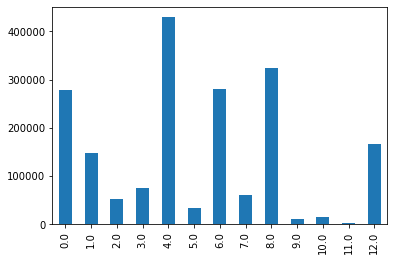

In [44]:
(orig_df["STAT_CAUSE_CODE"] - 1).value_counts().sort_index().plot.bar()

## Model prediction

In [45]:
def xgb_prediction(X_train, y_train, X_test):
    xgb = XGBClassifier(use_label_encoder=False, random_state=5)
    xgb = xgb.fit(X_train, y_train.astype(int))
    
    plot_importance(xgb, max_num_features=10, importance_type="weight")
    plot_importance(xgb, max_num_features=10, importance_type="gain")
    plot_importance(xgb, max_num_features=10, importance_type="cover")
    plt.show()
    
    y_predict_train = xgb.predict(X_train)
    y_predict_test = xgb.predict(X_test)
    
    return y_predict_train, y_predict_test,xgb

In [46]:
def logistic_regression_prediction(X_train, y_train, X_test):
    # I've fixed a random state because the data is already shuffled
    # The tunning of this model should be in class_weights None or 'balanced' and in C regularization (lower c = higher reg)
    lr = LogisticRegression(class_weight='balanced', random_state=17, multi_class='multinomial', C=1, max_iter=1000)
    lr.fit(X_train, y_train)
    return lr.predict(X_train), lr.predict(X_test),lr

In [47]:
def random_forest_prediction(X_train, y_train, X_test):
    #fill optimal hyper params later
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    return rf.predict(X_train), rf.predict(X_test),rf

### Run Cross Validation

In [48]:
# Run validation:

def run_validation(num_of_data_sets, prediction_model):
    
    num_of_data_sets = min(num_of_data_sets, SPLITS)
    
    train_score = [0] * num_of_data_sets
    val_score = [0] * num_of_data_sets
    
    for i in range(num_of_data_sets):
        part_train = pd.read_pickle(PICKLE_PARTIAL_TRAIN_DATA.format(i=i, folds=SPLITS-1))
        x_part_train = part_train.iloc[:, part_train.columns != "STAT_CAUSE_CODE"]
        y_part_train = part_train["STAT_CAUSE_CODE"] -1

        part_val = pd.read_pickle(PICKLE_PARTIAL_VALIDATION_DATA.format(i=i, folds=SPLITS-1))
        x_part_val = part_val.iloc[:,part_val.columns != "STAT_CAUSE_CODE"]
        y_part_val = part_val["STAT_CAUSE_CODE"] -1

        y_predict_train, y_predict_val,fitted_model = prediction_model(x_part_train, y_part_train, x_part_val)
        permutation_importance(fitted_model,x_part_val,y_part_val)
        train_score[i] = f1_score(y_part_train, y_predict_train, average='weighted')
        val_score[i] = f1_score(y_part_val, y_predict_val, average='weighted')

        disp = confusion_matrix(y_part_val, y_predict_val, normalize='true')
        disp = ConfusionMatrixDisplay(disp).plot()
        disp.figure_.set_size_inches(9,9)
        disp.ax_.set_title(f"Test Confusion Matrix, set {i} - normalized for each true label")
        
        plt.show()
    return train_score, val_score

In [49]:
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display
NUMBER_OF_FEATURES = 54
def permutation_importance(my_model,val_X,val_y):
    perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
    display(eli5.show_weights(perm, feature_names=val_X.columns.tolist(),top=NUMBER_OF_FEATURES))


[19:12:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


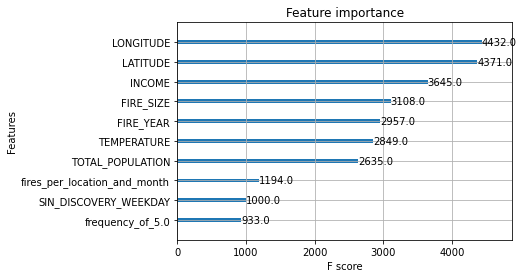

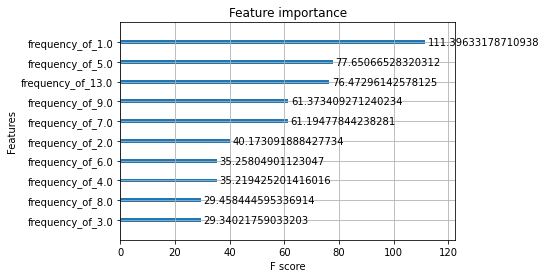

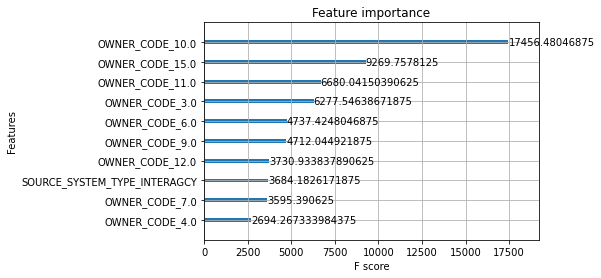

Weight,Feature
0.0768 ± 0.0016,frequency_of_1.0
0.0552 ± 0.0021,frequency_of_5.0
0.0450 ± 0.0012,FIRE_YEAR
0.0401 ± 0.0027,INCOME
0.0349 ± 0.0013,frequency_of_13.0
0.0342 ± 0.0021,frequency_of_7.0
0.0342 ± 0.0021,frequency_of_9.0
0.0189 ± 0.0018,SOURCE_SYSTEM_TYPE_NONFED
0.0184 ± 0.0019,LONGITUDE
0.0116 ± 0.0015,LATITUDE


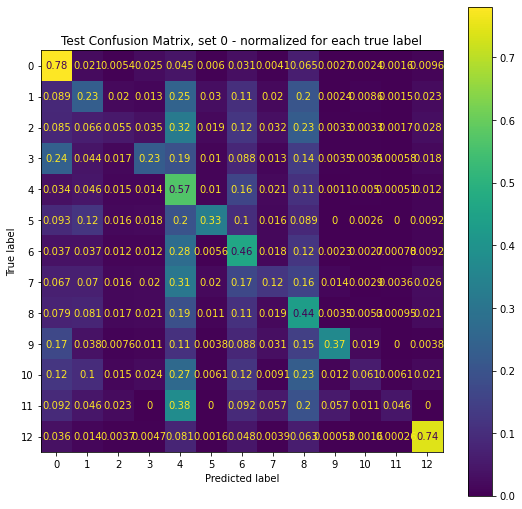

[19:22:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


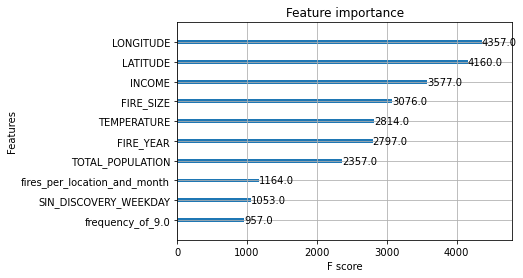

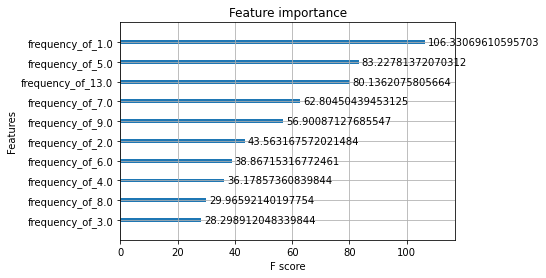

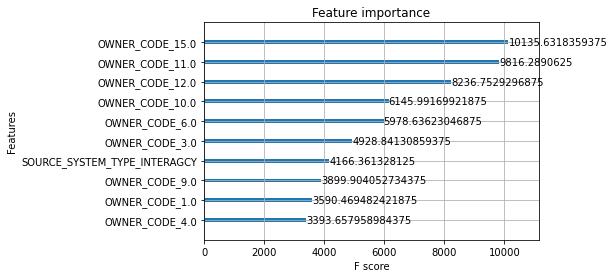

Weight,Feature
0.0829 ± 0.0021,frequency_of_1.0
0.0511 ± 0.0016,frequency_of_5.0
0.0429 ± 0.0010,FIRE_YEAR
0.0373 ± 0.0011,INCOME
0.0371 ± 0.0013,frequency_of_13.0
0.0335 ± 0.0029,frequency_of_9.0
0.0322 ± 0.0013,frequency_of_7.0
0.0274 ± 0.0013,SOURCE_SYSTEM_TYPE_NONFED
0.0159 ± 0.0025,LONGITUDE
0.0130 ± 0.0015,LATITUDE


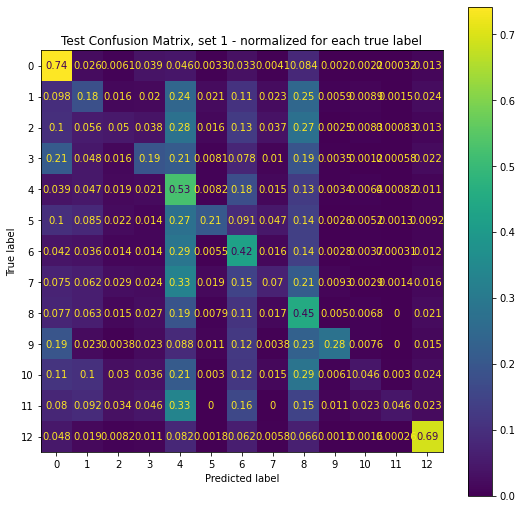

[19:31:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [50]:
train_score1, val_score1 = run_validation(5, xgb_prediction)

In [51]:
# XGBoost scores
# Train f1: mean=0.7258378627041111, SD=0.0006821483947345485
# Val f1: mean=0.46870440695517307, SD=0.015860682611354718

# print(f"Train f1: mean={np.mean(train_score1)}, SD={np.std(train_score1)}")
# print(f"Val f1: mean={np.mean(val_score1)}, SD={np.std(val_score1)}")

## Models hyper parameter search

In [ ]:
def run_grid_search(model, params_grid, train):

    x_train = train.iloc[:, train.columns != "STAT_CAUSE_CODE"]
    y_train = train["STAT_CAUSE_CODE"] -1

    grid = GridSearchCV(estimator=model, param_grid=params_grid, cv=5,
                        verbose=2, scoring=make_scorer(balanced_accuracy_score), n_jobs =4)
    grid.fit(x_train, y_train)
    return grid.best_params_, grid.best_score_, grid.best_estimator_


def grid_search_logistic_regression(train):
    model = LogisticRegression(random_state=17, multi_class='multinomial', max_iter=1000)
    params_grid = { 
        'class_weight': [None, 'balanced'],
        'C': [0.1, 0.5, 1, 2]
    }
    return run_grid_search(model, params_grid, train)


# e.g of usage
best_params1, best_score1, best_model1 = grid_search_logistic_regression(pre_processed_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
def run_random_search(model, random_grid, train_df):
    x_train = train_df.iloc[:, train_df.columns != "STAT_CAUSE_CODE"]
    y_train = train_df["STAT_CAUSE_CODE"] -1

    random_s = RandomizedSearchCV(estimator = model, param_distributions = random_grid,
                                  n_iter = 5, cv = 3, verbose=2,
                                  scoring=make_scorer(balanced_accuracy_score), n_jobs = 4)
    random_s.fit(X_train,y_train)
    return random_s.best_params_, random_s.best_score_, random_s.best_estimator_

def random_s_random_forest(train_df):
    rf = RandomForestClassifier()

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 5)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(3, 10, num = 5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    return run_random_search(rf, random_grid, traind_df)

    

In [ ]:
def run_grid_search(grid_search_model):
    
    train = pd.read_pickle(PICKLE_TOTAL_TRAIN_DATA)
    x_train = part_train.iloc[:, part_train.columns != "STAT_CAUSE_CODE"]
    y_train = part_train["STAT_CAUSE_CODE"] -1

    best_params, best_score, best_model = grid_search_model(x_train, y_train)

    return best_params, best_score, best_model

Logistic grid search best params
{'C': 1, 'class_weight': 'balanced'}
best score:
0.6062537208436696
best estimator:
LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=17)
important features by the best estimator :
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
 
Names of support columns:
['frequency_of_2.0', 'frequency_of_3.0', 'frequency_of_4.0',
 'frequency_of_5.0', 'frequency_of_6.0', 'frequency_of_7.0',
 'frequency_of_8.0', 'frequency_of_9.0', 'frequency_of_10.0',
 'frequency_of_11.0', 'frequency_of_12.0', 'frequency_of_13.0',
 'SOURCE_SYSTEM_TYPE_INTERAGCY', 'OWNER_CODE_4.0', 'OWNER_CODE_5.0']

In [ ]:
best_params1, best_score1, best_model1 = run_grid_search(grid_search_logistic_regression)

#finds most important feature for best logistic regressor
train = pd.read_pickle(PICKLE_TOTAL_TRAIN_DATA)
x_train = part_train.iloc[:, part_train.columns != "STAT_CAUSE_CODE"]
y_train = part_train["STAT_CAUSE_CODE"] -1
model = SelectFromModel(best_model1, prefit=True)
print([x_train.columns[i] for i in range(len(x_train.columns)) if model.get_support()[i]])

In [ ]:
# TODO: try models that work with categorical

In [ ]:
# jupyter nbextension enable --py widgetsnbextension

## Things that still need to be done

In [ ]:
# many categories
# TODO - maybe process strings
print(np.unique(orig_df["NWCG_REPORTING_UNIT_NAME"]))
print(len(np.unique(orig_df["NWCG_REPORTING_UNIT_NAME"])))

In [ ]:
# X = fixed_df.drop(["STAT_CAUSE_CODE"], axis=1)
# y = fixed_df["STAT_CAUSE_CODE"]

# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# reg = RandomForestClassifier()
# reg.fit(X_train, y_train)

# reg.score(X_test, y_test)


In [ ]:
# reg.feature_importances_


- 0   OBJECTID                    1880465 non-null  int64  - מספר סידורי, לא מעניין
-  1   FOD_ID                      1880465 non-null  int64  - מספר סידורי, לא מעניין
-  2   FPA_ID                      1880465 non-null  object - לא מעניין
-  3   SOURCE_SYSTEM_TYPE          1880465 non-null  object - אמור להיות שלושה סוגים? אולי רלוונטי? אולי דליפה?
-  4   SOURCE_SYSTEM               1880465 non-null  object - כמו למעלה
-  5   NWCG_REPORTING_AGENCY       1880465 non-null  object -הסוכנות שמילאה את הדוח, שם מספר אפשרויות בודדות
-  6   NWCG_REPORTING_UNIT_ID      1880465 non-null  object - כמעט אותו דבר כמו למטה
- 7   NWCG_REPORTING_UNIT_NAME    1880465 non-null  object - היחידה המקומית שטיפלה, 1000 אפשרויות ומאוד ספציפי
- 8   SOURCE_REPORTING_UNIT       1880465 non-null  object - אותו דבר, מהמקור
- 9   SOURCE_REPORTING_UNIT_NAME  1880465 non-null  object - אותו דבר, מהמקור
- 10  LOCAL_FIRE_REPORT_ID        421179 non-null   object - מעט מידי רשומות
- 11  LOCAL_INCIDENT_ID           1059644 non-null  object - קוד מזהה עבור סוכנות ספציפית בשנה ספציפית, כנראה ליקג?
- 12  FIRE_CODE                   324829 non-null   object -cמעט מידי, מחרוזות והרבה ייחודיים
- 13  FIRE_NAME                   923276 non-null   object - מעט מידי
- 14  ICS_209_INCIDENT_NUMBER     25717 non-null    object - מעט מידי
- 15  ICS_209_NAME                25717 non-null    object -מעט מידי
- 16  MTBS_ID                     11003 non-null    object - מעט מידי
- 17  MTBS_FIRE_NAME              11003 non-null    object - מעט מידי
- 18  COMPLEX_NAME                5183 non-null     object - מעט מידי
- 19  FIRE_YEAR                   1880465 non-null  int64  - השנה
- 20  DISCOVERY_DATE              1880465 non-null  float64 - התאריך
- 21  DISCOVERY_DOY               1880465 non-null  int64  - יום בשנה שהתגלה
- 22  DISCOVERY_TIME              997827 non-null   object - שעה שהתגלה
- 23  STAT_CAUSE_CODE             1880465 non-null  float64 - קוד לסיבה
- 24  STAT_CAUSE_DESCR            1880465 non-null  object - הסיבה
- 25  CONT_DATE                   988934 non-null   float64 - זמן שכובתה
- 26  CONT_DOY                    988934 non-null   float64 - יום שכובתה
- 27  CONT_TIME                   908292 non-null   object  - זמן שכובתה
- 28  FIRE_SIZE                   1880465 non-null  float64 - גודל השריפה
- 29  FIRE_SIZE_CLASS             1880465 non-null  object - קידוד של הגודל לשש קטגוריות
- 30  LATITUDE                    1880465 non-null  float64 - קוארדינטות
- 31  LONGITUDE                   1880465 non-null  float64 - קואורדינטות
- 32  OWNER_CODE                  1880465 non-null  float64 - קוד של מי שהבעלות על האדמה שלו
- 33  OWNER_DESCR                 1880465 non-null  object - כמו קודם רק תיאור
- 34  STATE                       1880465 non-null  object - מדינה
- 35  COUNTY                      1202317 non-null  object - מחוז
- 36  FIPS_CODE                   1202317 non-null  object - בערך 300 מזהים 
- 37  FIPS_NAME                   1202317 non-null  object - בערך 1700 
- 38  Shape                       1880465 non-null  objec - לא רלוונטי